In [1]:
import sys
sys.path.append('..')

import uproot

import numpy as np
import pandas as pd
import awkward as ak
import matplotlib.pyplot as plt
import seaborn as sns

from skimage.measure import label, regionprops
from scipy.ndimage import label as scipy_label
from collections import deque

from lariat import Event

In [16]:
deuterons = pd.read_csv('/Users/user/data/research/proton-deuteron/csv/deuteron_candidates_bbox_t100.csv') # from within vertices bounding box
pickydeuterons = pd.read_csv("/Users/user/data/research/proton-deuteron/csv/pickydeuterons.csv")

In [237]:
allclusters = pd.read_pickle("/Users/user/data/research/proton-deuteron/csv/allclusters.pkl")

In [196]:
allclusters

,event_idx,run,subrun,event,file_path,event_index,particle_type,plane,cluster_idx,area,...,bbox_min_col,bbox_max_row,bbox_max_col,width,height,aspect_ratio,compactness,image_intensity,matrix_transformed,column_maxes
0,0,8667,148,10828,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,0,9047.0,...,154,196,944,790,171,4.619883,0.066970,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[16.0, -0.0, -0.0, 0.0, -0.0, -0.0, -0.0, 0.0...","[30.0, 99.0, 109.0, 78.0, 78.0, 80.0, 85.0, 78..."
1,0,8667,148,10828,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,1,22.0,...,888,36,910,22,1,22.000000,1.000000,"[[16.0, 18.0, 20.0, 21.0, 23.0, 24.0, 25.0, 26...","[[17.0], [18.0], [20.0], [21.0], [22.0], [23.0...",[27.0]
2,0,8667,148,10828,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,2,29.0,...,484,174,513,29,1,29.000000,1.000000,"[[16.0, 18.0, 19.0, 21.0, 23.0, 25.0, 27.0, 28...","[[16.0], [17.0], [19.0], [20.0], [22.0], [23.0...",[33.0]
3,0,8667,148,10828,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,3,24.0,...,369,197,393,24,1,24.000000,1.000000,"[[16.0, 16.0, 16.0, 17.0, 17.0, 17.0, 17.0, 18...","[[16.0], [16.0], [17.0], [17.0], [17.0], [17.0...",[18.0]
4,0,8667,148,10828,/Users/user/data/research/proton-deuteron/rawd...,0,deuteron,collection,4,31.0,...,188,198,219,31,1,31.000000,1.000000,"[[17.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0, 32...","[[17.0], [18.0], [20.0], [21.0], [23.0], [24.0...",[37.0]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438570,7635,9788,311,27225,/Users/user/data/research/proton-deuteron/rawp...,0,proton,collection,4,31.0,...,2570,93,2601,31,1,31.000000,1.000000,"[[16.0, 18.0, 19.0, 21.0, 23.0, 24.0, 26.0, 27...","[[16.0], [18.0], [19.0], [20.0], [21.0], [23.0...",[33.0]
438571,7635,9788,311,27225,/Users/user/data/research/proton-deuteron/rawp...,0,proton,collection,5,27.0,...,277,115,304,27,1,27.000000,1.000000,"[[16.0, 18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 29...","[[16.0], [18.0], [20.0], [21.0], [23.0], [24.0...",[33.0]
438572,7635,9788,311,27225,/Users/user/data/research/proton-deuteron/rawp...,0,proton,induction,0,1559.0,...,1101,83,1239,138,56,2.464286,0.201734,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[16.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0...","[23.0, 43.0, 54.0, 62.0, 51.0, 51.0, 56.0, 59...."
438573,7635,9788,311,27225,/Users/user/data/research/proton-deuteron/rawp...,0,proton,induction,1,24.0,...,2707,79,2731,24,1,24.000000,1.000000,"[[17.0, 19.0, 22.0, 25.0, 27.0, 30.0, 33.0, 35...","[[20.0], [25.0], [29.0], [34.0], [37.0], [40.0...",[45.0]


In [3]:
picky = pd.merge(deuterons,
                 pickydeuterons,
                 on=['run', 'subrun', 'event'],
                 how='inner')

picky = picky.drop_duplicates(subset=['run', 'subrun', 'event']).reset_index(drop=True)

picky.head()

,run,subrun,event,file_path,event_index,col_max_adc,ind_max_adc,col_activity_pixels,ind_activity_pixels,p,m,beamline_mass
0,8596,410,37727,/Users/user/data/research/proton-deuteron/rawd...,0,94.0,42.0,52,0,1,0,1822.06
1,9473,109,9096,/Users/user/data/research/proton-deuteron/rawd...,0,162.0,127.0,730,84,1,0,1869.80
2,9783,28,4265,/Users/user/data/research/proton-deuteron/rawd...,0,396.0,192.0,775,109,1,0,1826.83
3,8667,39,2811,/Users/user/data/research/proton-deuteron/rawd...,0,126.0,101.0,245,188,1,1,2032.23
4,9481,248,19285,/Users/user/data/research/proton-deuteron/rawd...,0,243.0,120.0,923,107,1,0,2331.43


In [207]:
i = 186
row = picky.iloc[i]

In [218]:
row

run                                                                 8557
subrun                                                               168
event                                                               7815
file_path              /Users/user/data/research/proton-deuteron/rawd...
event_index                                                            0
col_max_adc                                                        309.0
ind_max_adc                                                        159.0
col_activity_pixels                                                  760
ind_activity_pixels                                                  264
p                                                                      1
m                                                                      1
beamline_mass                                                    1989.77
Name: 186, dtype: object

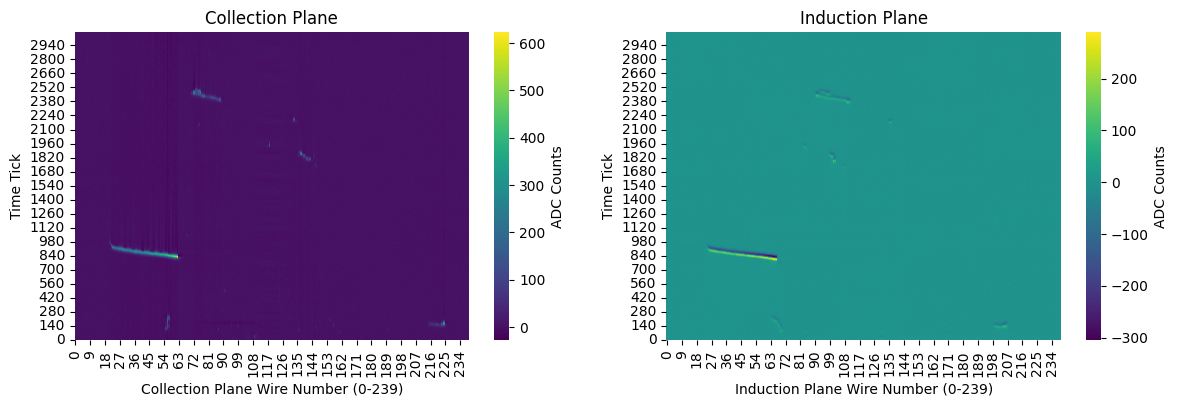

In [208]:
event = Event(row['file_path'], row['event_index'], threshold=15)

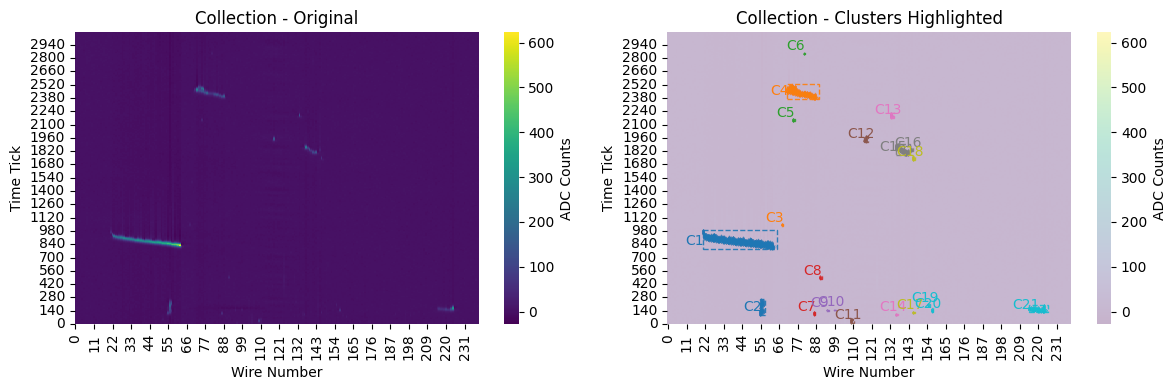

In [209]:
event.visualiseclusters(event.collection, event.connectedcr, 'Collection', mode='highlight')

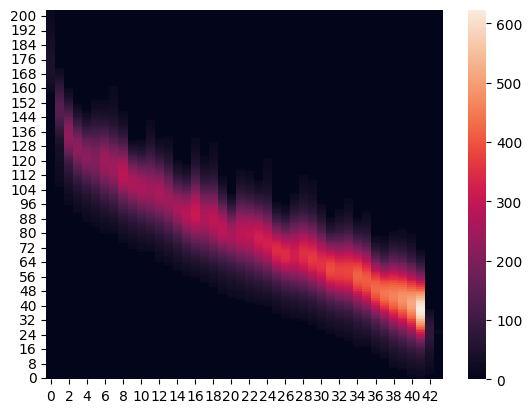

In [210]:
c = 0
sns.heatmap(event.connectedcr[c].image_intensity.T)
plt.gca().invert_yaxis()

This would not make it becuase of length cut on the clusters that I had used to remove actual noise.

In [211]:
maxing = np.max(event.connectedcr[c].image_intensity.T, axis=0)
maxing

array([ 46., 138., 228., 222., 216., 205., 249., 248., 289., 265., 262.,
       247., 261., 247., 260., 282., 309., 271., 292., 289., 264., 290.,
       297., 322., 323., 344., 345., 322., 349., 364., 356., 391., 378.,
       383., 418., 411., 427., 445., 460., 483., 515., 623.,  80.,  16.])

In [212]:
normalised = []

minimum = 0
maximum = np.max(maxing)

if maximum > minimum:
    normalised_signal = (maxing - minimum) / (maximum - minimum)
else:
    normalised_signal = np.zeros_like(maxing, dtype=float)
    print('Error: Max not greater than min in signal.')
normalised.append(normalised_signal)

adcdiff = [np.diff(signal) for signal in normalised]; 
maxdiff = [np.max(diff) for diff in adcdiff]; 

In [213]:
normalised

[array([0.07383628, 0.22150883, 0.36597111, 0.35634029, 0.34670947,
        0.32905297, 0.39967897, 0.39807384, 0.46388443, 0.42536116,
        0.42054575, 0.3964687 , 0.41894061, 0.3964687 , 0.41733547,
        0.45264848, 0.49598716, 0.43499197, 0.46869984, 0.46388443,
        0.42375602, 0.46548957, 0.47672552, 0.51685393, 0.51845907,
        0.55216693, 0.55377207, 0.51685393, 0.56019262, 0.58426966,
        0.57142857, 0.62760835, 0.60674157, 0.61476726, 0.67094703,
        0.65971108, 0.68539326, 0.71428571, 0.73836276, 0.7752809 ,
        0.82664526, 1.        , 0.12841091, 0.02568218])]

In [214]:
adcdiff

[array([ 0.14767255,  0.14446228, -0.00963082, -0.00963082, -0.0176565 ,
         0.070626  , -0.00160514,  0.06581059, -0.03852327, -0.00481541,
        -0.02407705,  0.02247191, -0.02247191,  0.02086677,  0.035313  ,
         0.04333868, -0.06099518,  0.03370787, -0.00481541, -0.04012841,
         0.04173355,  0.01123596,  0.04012841,  0.00160514,  0.03370787,
         0.00160514, -0.03691814,  0.04333868,  0.02407705, -0.01284109,
         0.05617978, -0.02086677,  0.00802568,  0.05617978, -0.01123596,
         0.02568218,  0.02889246,  0.02407705,  0.03691814,  0.05136437,
         0.17335474, -0.87158909, -0.10272873])]

In [215]:
maxdiff

[np.float64(0.173354735152488)]

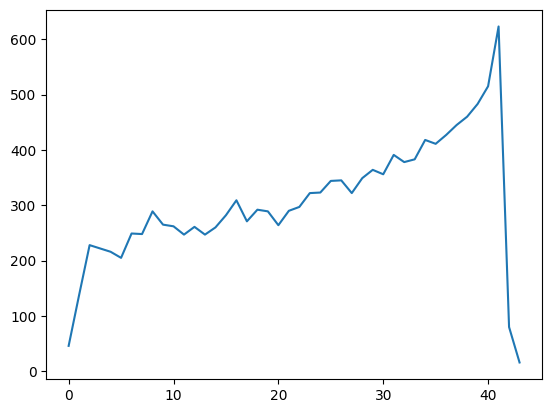

In [216]:
plt.plot(maxing)
plt.show()

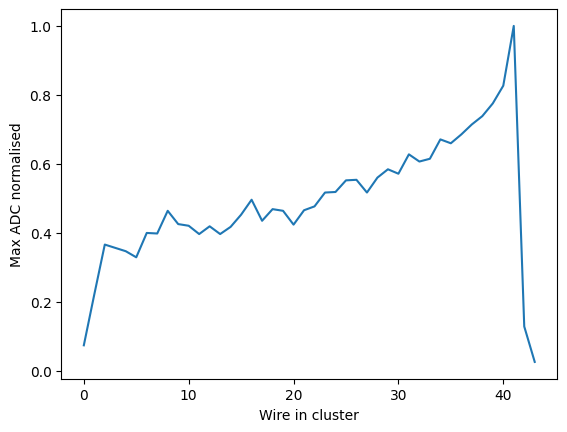

In [217]:
plt.plot(normalised[0]); plt.xlabel('Wire in cluster'); plt.ylabel('Max ADC normalised'); plt.show()

All clusters

In [82]:
clusters = pd.merge(allclusters,
                 pickydeuterons,
                 on=['run', 'subrun', 'event'],
                 how='inner')

# clusters = clusters.drop_duplicates(subset=['run', 'subrun', 'event']).reset_index(drop=True)

In [83]:
# clusters = clusters.groupby(['run', 'subrun', 'event'])

In [84]:
clusters = clusters.sort_values(['run', 'subrun', 'event']).set_index(['run', 'subrun', 'event'])

In [92]:
i = 6
g = picky[['run', 'subrun', 'event']].iloc[i]
cs = clusters.loc[tuple(g)]

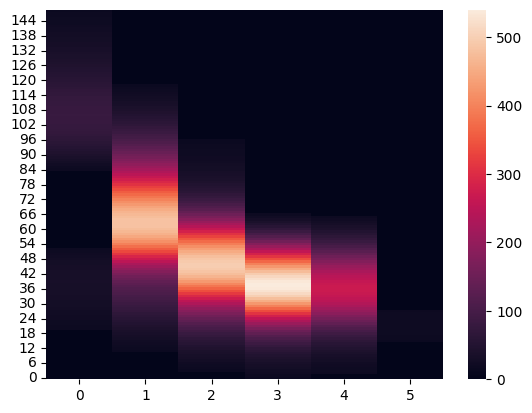

In [93]:
c = 1
t = cs.iloc[c]
sns.heatmap(t.image_intensity.T)
plt.gca().invert_yaxis()

Seperating Protons and Muons

In [249]:
lcut = allclusters[
    (allclusters['column_maxes'].map(len) > 1) &
    (allclusters['column_maxes'].map(lambda x: len(set(x)) > 1))
    ].reset_index(drop=True)

print(allclusters.shape); print(lcut.shape) 


(438575, 27)
(203482, 27)


In [250]:
maxes = lcut['column_maxes'].values; len(maxes)

203482

In [254]:
normalised = []

for i, signal in enumerate(maxes):
    minimum = 0
    maximum = np.max(signal)

    if maximum > minimum:
        normalised_signal = (signal - minimum) / (maximum - minimum)
    else:
        normalised_signal = np.zeros_like(signal, dtype=float)
        print(f'Error: Max not greater than min in signal {i}.')
    normalised.append(normalised_signal)

lcut['normalised'] = normalised
adcdiff = [np.diff(signal) for signal in normalised]; lcut['adcdiff'] = adcdiff
maxdiff = [np.max(diff) for diff in adcdiff]; lcut['maxdiff'] = maxdiff

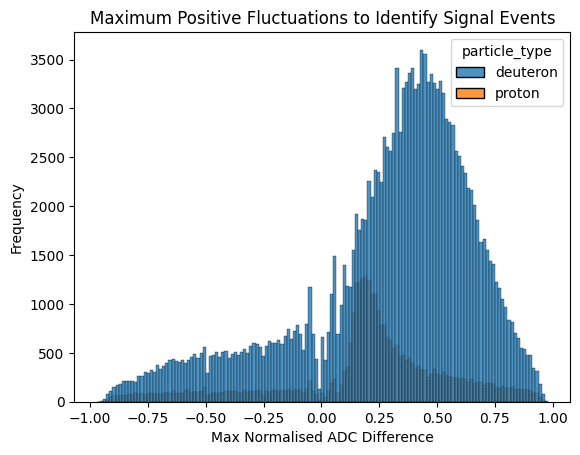

In [ ]:
plt.figure()

sns.histplot(data=lcut,
             x='maxdiff',
             hue='particle_type',
             bins='auto',
             alpha=0.8)

# plt.axvline(0.26, color='red', linestyle=':' )

plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Frequency')
plt.title('Maximum Positive Fluctuations to Identify Signal Events')
plt.show()

In [262]:
negatives = lcut[lcut['maxdiff'] < 0].reset_index(drop=True)

In [295]:
negatives.shape

(38236, 31)

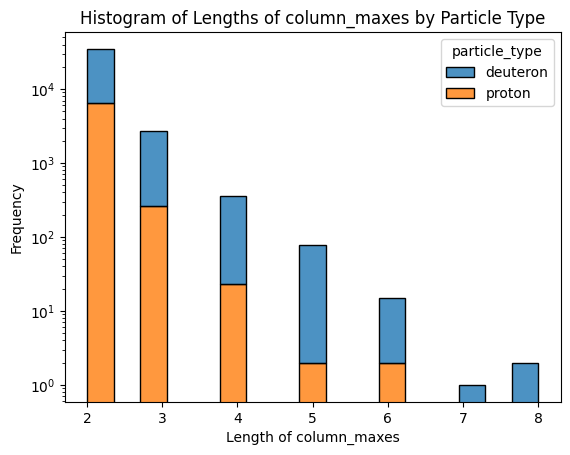

(array([  137,  1695,  1965, 12962, 17295, 17397, 17489, 18028, 22096,
        22634, 26529, 29786, 30667, 32181, 35470]),)

In [298]:
lengths = negatives['column_maxes'].map(len)
negatives['lengths'] = lengths  # Add as a column for seaborn

plt.figure()
sns.histplot(data=negatives, x='lengths', hue='particle_type', bins='auto', multiple='stack', alpha=0.8)
plt.xlabel('Length of column_maxes')
plt.ylabel('Frequency')
plt.yscale('log')
plt.title('Histogram of Lengths of column_maxes by Particle Type')
plt.show()

a = np.where(lengths == 6)
a

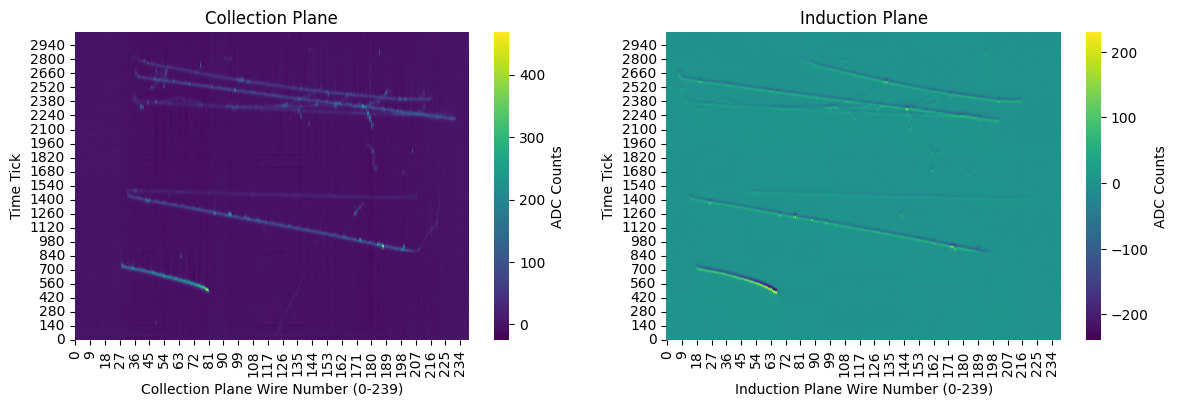

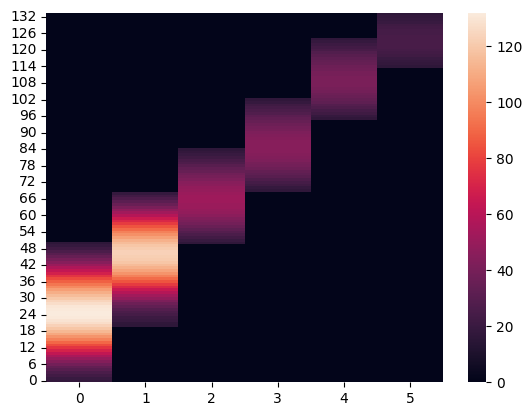

In [302]:
i = 22096
negative = Event(negatives.iloc[i]['file_path'], negatives.iloc[i]['event_index'])
sns.heatmap(negatives.iloc[i]['image_intensity'].T)
plt.gca().invert_yaxis()

Negatives are all noise. Remove.

In [303]:
ncut = lcut[lcut['maxdiff'] >= 0].reset_index(drop=True)

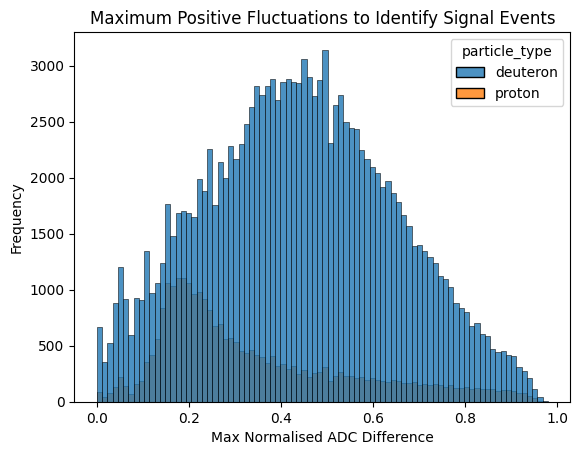

In [306]:
plt.figure()

sns.histplot(data=ncut,
             x='maxdiff',
             hue='particle_type',
             bins='auto',
             alpha=0.8)

# plt.axvline(0.26, color='red', linestyle=':' )

plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Frequency')
plt.title('Maximum Positive Fluctuations to Identify Signal Events')
plt.show()

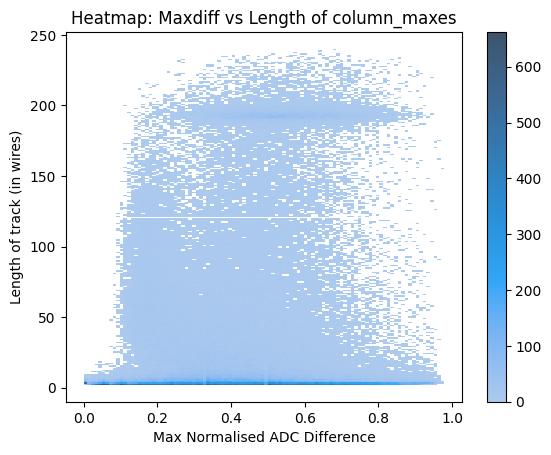

In [341]:
ncut['lengths'] = ncut['column_maxes'].map(len)

plt.figure()
sns.histplot(data=ncut, x='maxdiff', y='lengths', bins=[100, 240], cbar=True)
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of track (in wires)')
plt.title('Heatmap: Maxdiff vs Length of column_maxes')
plt.show()

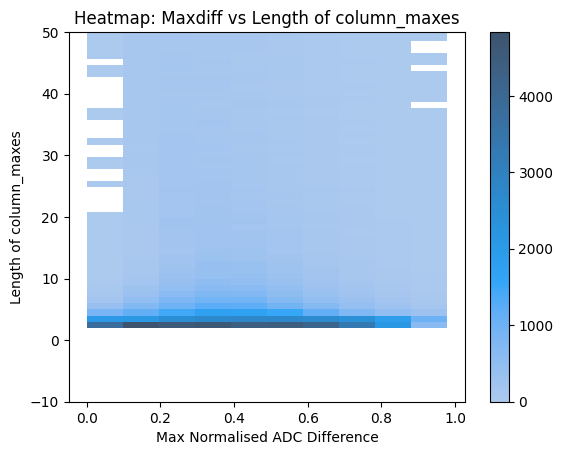

In [339]:
ncut['lengths'] = ncut['column_maxes'].map(len)

plt.figure()
sns.histplot(data=ncut, x='maxdiff', y='lengths', bins=[10, 240], cbar=True)
plt.xlabel('Max Normalised ADC Difference')
plt.ylabel('Length of column_maxes')
plt.ylim(-10, 50)
plt.title('Heatmap: Maxdiff vs Length of column_maxes')
plt.show()

146

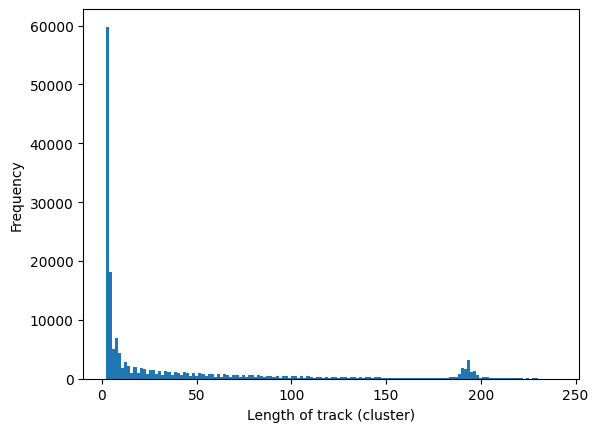

In [340]:
a = plt.hist(ncut['lengths'], bins='auto'); plt.xlabel('Length of track (cluster)'); plt.ylabel('Frequency')
plt.plot()
len(a[0])

[]

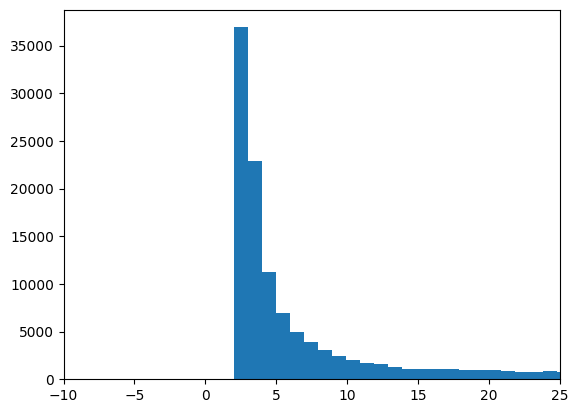

In [328]:
plt.hist(ncut['lengths'], bins=240)
plt.xlim(-10, 25)
plt.plot()